## Zhuo Liuzhou, 30Jul2021

# 1.1	Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import holidays
import yfinance as yf
pd.options.mode.chained_assignment = None

In [2]:
sample = pd.read_excel('Sample Dataset.xlsx')
sample.index = range(1,len(sample)+1)
sample.head()

,Date,Signal,Open,High,Low,Close,Adj Close
1,2015-11-19,13.768540,116.440002,116.650002,115.739998,116.059998,108.281601
2,2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323
3,2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453
4,2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837
5,2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159


In [3]:
sample.describe()

,Signal,Open,High,Low,Close,Adj Close
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,16.766190,141.847360,142.691801,140.907746,141.840973,136.341060
std,3.095783,18.475574,18.470255,18.404504,18.497010,21.427837
min,0.000000,94.080002,95.400002,93.639999,94.790001,-152.277847
25%,14.691150,132.132496,132.912495,130.542503,131.824993,125.290491
50%,17.298240,146.769997,147.959999,145.634995,146.885002,142.667732
75%,19.030890,155.367496,156.287495,154.422500,155.289993,151.798325
max,35.434147,172.789993,173.389999,171.949997,196.279999,168.842270


one can easily find that **“Adj Close” contain negative value**, and **max of “Close” is larger than max of “High”** both of which are impossible in real market, will address this error in below health checks.

I did below health checks:  
$~~~~$(1).	No missing signals or prices  
$~~~~$(2).	Dates are correct:  
$~~~~~~~~~$a.	No duplicate dates  
$~~~~~~~~~$b.	Dates are ordered  
$~~~~~~~~~$c.	No weekends   
$~~~~~~~~~$d.	No public holidays  
$~~~~~~~~~$e.	No missing workdays  
$~~~~$(3).	All prices look right:  
$~~~~~~~~~$a.	All prices are positive  
$~~~~~~~~~$b.	“Low” < (“Open”, “Close”) < “High” for each day  
$~~~~~~~~~$c.  “Adj Close” looks right  
$~~~~$(4).	Signal Outliers  
  
And the errors and correction are listed below, noted that the correction will be done after the checks to consider interaction between errors.

# (1)	No Null signals or prices.

In [4]:
sample.isnull().any(axis = 0)

Date         False
Signal       False
Open         False
High         False
Low          False
Close        False
Adj Close    False
dtype: bool

# (2) Dates:

## a. No duplicate dates

In [5]:
len(sample['Date'].unique()) == len(sample['Date'])

True

## b. Dates are in ascending order

In [6]:
dateDiff = (sample['Date'].diff())[1:]
all([d.days >0 for d in dateDiff])

True

## c. Weekends

In [7]:
weekends_index = []
weekends = []
for i in sample.index:
    if pd.Timestamp.weekday(sample.loc[i,'Date'])>4:
        weekends.append(sample.loc[i,'Date'])
        weekends_index.append(i)
weekends

[Timestamp('2018-05-19 00:00:00'),
 Timestamp('2018-05-20 00:00:00'),
 Timestamp('2018-06-23 00:00:00'),
 Timestamp('2018-06-24 00:00:00')]

**The data has 4 records on weekends**

In [8]:
sample.loc[weekends_index[0]:weekends_index[1]+2]

,Date,Signal,Open,High,Low,Close,Adj Close
630,2018-05-19,20.448445,162.369995,163.240005,162.360001,162.940002,157.493622
631,2018-05-20,19.483907,163.259995,163.330002,161.630005,161.759995,156.352997
632,2018-05-21,19.031457,162.369995,163.240005,162.360001,162.940002,157.493622
633,2018-05-22,19.823488,163.259995,163.330002,161.630005,161.759995,156.352997


In [9]:
sample.loc[weekends_index[2]:weekends_index[3]+2]

,Date,Signal,Open,High,Low,Close,Adj Close
656,2018-06-23,18.995502,167.240005,167.369995,164.139999,165.080002,159.562042
657,2018-06-24,20.274163,165.229996,166.660004,164.850006,166.039993,160.489944
658,2018-06-25,21.123096,167.240005,167.369995,164.139999,165.080002,159.562042
659,2018-06-26,20.198530,165.229996,166.660004,164.850006,166.039993,160.489944


From above can see those prices are the **same as next two workdays, correction is to remove these signals and prices.**

## d. Public holidays

In [10]:
pub_hol_index = []
pub_hol = []
us_holidays = pd.read_excel('US mkt holidays.xlsx')
us_holidays = us_holidays['Date'].tolist()

In [11]:
for i in sample.index:
    if sample.loc[i,'Date'] in us_holidays:
        pub_hol.append(sample.loc[i,'Date'])
        pub_hol_index.append(i)
print(pub_hol)

[Timestamp('2017-07-04 00:00:00')]


**The data has 1 record on public holidays (US holiday)**

In [12]:
sample.loc[pub_hol_index[0]-2:pub_hol_index[0]+2]

,Date,Signal,Open,High,Low,Close,Adj Close
406,2017-06-30,16.482053,141.250000,141.669998,140.770004,140.919998,134.474945
407,2017-07-03,16.803540,141.339996,142.500000,141.300003,142.100006,135.600998
408,2017-07-04,15.282748,141.339996,142.600000,141.400003,142.200006,135.700998
409,2017-07-05,15.282748,141.699997,141.850006,140.699997,141.589996,135.114380
410,2017-07-06,15.811562,139.929993,140.470001,138.830002,139.139999,133.349945


The prices of this record are not exactly the same as its neighboring records but are very close to last record (all of High, Low, Close and Adj Close are just **+0.1 from last record**), so guess is autofill down from last record. **Correction is to remove this record.**

# e. Missing working days

In [13]:
sample['Date'].max()

Timestamp('2020-01-06 00:00:00')

In [14]:
start_date = sample['Date'].min()
mis_workday = []
while start_date < sample['Date'].max():
    if pd.Timestamp.weekday(start_date) <5 and start_date not in us_holidays:
        if start_date not in sample['Date'].tolist():
            mis_workday.append(start_date)
    start_date += datetime.timedelta(days=1)
mis_workday

[Timestamp('2018-11-12 00:00:00'),
 Timestamp('2018-11-13 00:00:00'),
 Timestamp('2018-11-14 00:00:00'),
 Timestamp('2018-11-15 00:00:00'),
 Timestamp('2018-11-16 00:00:00')]

**The dataset has 5 missing working days.** Prices for dates between 12Nov2018 – 16Nov2018 (5 working days) is missing, correction is described in below section 1.1 correction

# (3) Prices:

## a. Negative prices

In [15]:
sample[(sample.loc[:,'Open':'Adj Close']<0).any(axis = 1)]

,Date,Signal,Open,High,Low,Close,Adj Close
733,2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,-152.277847


In [16]:
sample[(sample.loc[:,'Open':'Adj Close']<0).any(axis = 1)].index

Int64Index([733], dtype='int64')

**1 day has negative price**: as pointed out before, the “Adj Close” contains one negative value, and it should be computer “typo” 

## b. “Low” < (“Open”, “Close”) < “High”

In [17]:
def price_correct_check(df):
    res = ''
    if df['Low']>df['High']:
        res+='1'
    if df['Close']>df['High']:
        res+='2'
    if df['Close']<df['Low']:
        res+='3'
    if df['Open']>df['High']:
        res+='4'
    if df['Open']<df['Low']:
        res+='5'
    return res

In [18]:
wrong_price = sample.apply(price_correct_check, axis = 1)
wrong_price = wrong_price[wrong_price.apply(len)>0]

In [19]:
print("Number of illegal records: {}".format(len(wrong_price)))

Number of illegal records: 20


In [20]:
sample.loc[wrong_price.index].head()

,Date,Signal,Open,High,Low,Close,Adj Close
408,2017-07-04,15.282748,141.339996,142.600000,141.400003,142.200006,135.700998
432,2017-08-07,16.298805,140.440002,140.350000,139.710007,140.440002,134.595871
456,2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198
457,2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198
458,2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198


**In total there are 20 days with prices not fulfilling “Low” < (“Open”, “Close”) < “High” rule.**  
**Correction is described in below correction section**

## c. Adj Close

The "Adj Close" if similar to Yahoo Finance, is just "Close" adjusted for dividends and stock split. So the ratio of "Close" to "Adj Close" should be persistent for a period of time.

And because in (3)-a I already detected a negative Adj Close records, so in this section I'll first correct that to positive value then examine.

In [21]:
sample['Adj/Close'] = np.abs(sample['Adj Close']/sample['Close'])
sample['Adj/Close']

1       0.932980
2       0.932979
3       0.932979
4       0.932980
5       0.932979
          ...   
1034    0.989021
1035    0.989021
1036    0.989021
1037    0.989021
1038    0.989021
Name: Adj/Close, Length: 1038, dtype: float64

In [22]:
count, division = np.histogram(sample['Adj/Close'])
list(zip(count,division))

[(1, 0.7678226093734595),
 (0, 0.8158432673157043),
 (0, 0.8638639252579492),
 (464, 0.911884583200194),
 (571, 0.9599052411424389),
 (0, 1.0079258990846838),
 (0, 1.0559465570269286),
 (0, 1.1039672149691735),
 (1, 1.1519878729114184),
 (1, 1.2000085308536632)]

From the histogram count we can see there are three abnormal "Adj Close", and since the number is not large, I examined them one by one

**No. 1:**

In [23]:
sample.loc[sample[sample['Adj/Close']<0.8].index[0]-2:].head()

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
584,2018-03-15,18.100298,158.100006,158.139999,156.369995,156.919998,151.325409,0.964348
585,2018-03-16,19.385186,156.979996,158.270004,156.750000,157.800003,152.174042,0.964348
586,2018-03-19,18.660897,157.169998,157.210007,154.449997,196.279999,150.708221,0.767823
587,2018-03-20,19.177721,156.669998,157.020004,155.770004,156.240005,150.669647,0.964347
588,2018-03-21,19.019439,156.320007,158.259995,156.199997,157.149994,151.547241,0.964348


In [24]:
sample[sample['Adj/Close']<0.8].index[0] in wrong_price.index

True

Noted that this one is due to the illegal "Close" (larger than "High"), so after adjustment (set "Close" = "High") the Adj/CLose becomes:

In [25]:
sample.loc[586,'Adj Close']/sample.loc[586,'High']

0.9586426708829039

which looks normal comparing to its neighborning records.

**No. 2:**

In [26]:
sample[sample[(sample['Adj/Close']<1.2) &\
              (sample['Adj/Close']>1)].index[0]-3:].head()

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
337,2017-03-23,15.705048,134.000000,135.699997,133.639999,134.779999,128.246490,0.951525
338,2017-03-24,15.131940,134.949997,135.470001,133.860001,134.490005,128.339050,0.954265
339,2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,158.577637,1.176916
340,2017-03-28,16.215369,134.279999,135.899994,134.139999,135.789993,129.579605,0.954265
341,2017-03-29,15.265496,135.699997,136.490005,135.300003,136.229996,129.999481,0.954265


In [27]:
sample[(sample['Adj/Close']<1.2) &\
       (sample['Adj/Close']>1)].index[0] in wrong_price.index

False

This one's prices look right, so is due to abnormal "Adj Close", and the records before and after it all have Adj Close/Close ratio of 0.954265, so this one should have the same ratio. **Correction is to adjust the "Adj Close" so that "Adj Close"/"Close" for 27Mar2017 = 0.954265**

**No. 3:**

In [28]:
sample[sample[sample['Adj/Close']>1.2].index[0]-3:].head()

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
261,2016-12-01,15.304759,132.250000,132.550003,130.289993,130.970001,124.109283,0.947616
262,2016-12-02,14.990113,130.940002,131.470001,130.520004,130.899994,124.042938,0.947616
263,2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,166.175079,1.248029
264,2016-12-06,15.885051,133.520004,134.910004,132.740005,134.589996,127.539658,0.947616
265,2016-12-07,15.406135,134.589996,136.179993,134.179993,135.899994,128.781036,0.947616


In [29]:
sample[sample['Adj/Close']>1.2].index[0] in wrong_price.index

False

This one's issue is same as No. 2, **correction is to adjust the "Adj Close" so that "Adj Close"/"Close" for 27Mar2017 = 0.947616**

# (4) Signals

## a. Signals with value "0"

In [30]:
sample[sample['Signal']==0]

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
1033,2019-12-27,0.0,167.119995,167.119995,165.429993,165.860001,164.039063,0.989021
1034,2019-12-30,0.0,165.979996,166.210007,164.570007,165.440002,163.623688,0.989021
1035,2019-12-31,0.0,165.080002,166.350006,164.710007,165.669998,163.851135,0.989021
1036,2020-01-02,0.0,166.740005,166.750000,164.229996,165.779999,163.959946,0.989021
1037,2020-01-03,0.0,163.740005,165.410004,163.699997,165.130005,163.317093,0.989021
1038,2020-01-06,0.0,163.850006,165.539993,163.539993,165.350006,163.534668,0.989021


## b. Extremely large or small values

<AxesSubplot:>

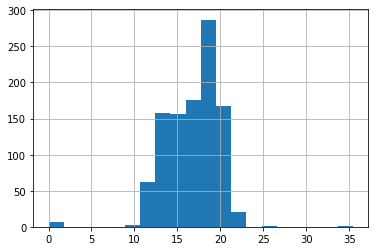

In [31]:
sample['Signal'].hist(bins=20)

In [32]:
count, division = np.histogram(sample['Signal'])
list(zip(count,division))

[(6, 0.0),
 (0, 3.5434147008000005),
 (2, 7.086829401600001),
 (220, 10.630244102400003),
 (332, 14.173658803200002),
 (455, 17.717073504000002),
 (21, 21.260488204800005),
 (1, 24.803902905600005),
 (0, 28.347317606400004),
 (1, 31.890732307200004)]

In [33]:
sample.loc[sample[sample['Signal']>35].index[0]-2:].head()

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
499,2017-11-09,17.361475,146.270004,147.389999,145.279999,146.679993,140.916534,0.960707
500,2017-11-10,17.628384,146.710007,147.100006,146.350006,146.570007,140.810852,0.960707
501,2017-11-13,35.434147,145.929993,146.820007,145.500000,146.610001,140.849274,0.960707
502,2017-11-14,17.456319,146.059998,146.490005,145.589996,146.210007,140.465012,0.960707
503,2017-11-15,17.928089,145.350006,146.210007,144.500000,145.630005,139.907806,0.960707


The histogram of signal shows an outlier in the right, with value of 35.43, looking at this record, the prices are not abnormal at that day, so it is highly likely this signal is wrong, will **remove this record** when evaluating the efficacy.

# 1.1 Corrections

## (2) c & d. Weekends and public holidays

In [34]:
newdata = sample.drop(index = weekends_index + pub_hol_index)
newdata.index = range(1,len(newdata)+1)

## (2) e. Missing workdays 12Nov2018 - 16Nov2018

**Correction to signals: set them to be zero  
Correction to price: interpolation using 9Nov2018 and 19Nov2018 prices**
-	Close is linearly interpolated from 9Nov to 19Nov, with increments of (148.86-154.08)/6 = -0.87
-	Open(T) = Close(T-1)
-	High = Open, Low = Close, since 19Nov2018 Close < 9Nov2018 Close
-	Adj Close(T) = Close(T) * Adj Close(9Nov2018)/Close(9Nov2018)

In [35]:
mis_df = pd.DataFrame(np.zeros((5,8)),columns = sample.columns)
mis_df.loc[:,'Date'] = mis_workday
start_v = sample[sample['Date']=='2018/11/9']['Close'].tolist()[0]
end_v = sample[sample['Date']=='2018/11/19']['Close'].tolist()[0]
inc = (end_v-start_v)/6
mis_df.loc[:,'Close'] = np.cumsum([start_v]+[inc]*5)[1:]
mis_df.loc[:,'Open'] = [start_v]+mis_df.loc[:,'Close'].tolist()[:-1]
mis_df.loc[:,'High'] = mis_df['Open']
mis_df.loc[:,'Low'] = mis_df['Close']
adj_close = sample[sample['Date']=='2018/11/9']['Adj Close'].tolist()[0]\
    /sample[sample['Date']=='2018/11/9']['Close'].tolist()[0]
mis_df.loc[:,'Adj Close'] = mis_df['Close']*adj_close
mis_df.loc[:,'Adj/Close'] = adj_close

newdata = pd.concat([newdata,mis_df])
newdata = newdata.sort_values(['Date'])
newdata.index = range(1,len(newdata)+1)

In [36]:
newdata[newdata['Date']>'2018/11/8'].head(n=7)

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
750,2018-11-09,19.074848,156.000000,156.029999,152.949997,154.080002,149.865677,0.972648
751,2018-11-12,0.000000,154.080002,154.080002,153.210002,153.210002,149.019473,0.972648
752,2018-11-13,0.000000,153.210002,153.210002,152.340002,152.340002,148.173268,0.972648
753,2018-11-14,0.000000,152.340002,152.340002,151.470001,151.470001,147.327064,0.972648
754,2018-11-15,0.000000,151.470001,151.470001,150.600001,150.600001,146.480860,0.972648
755,2018-11-16,0.000000,150.600001,150.600001,149.730001,149.730001,145.634655,0.972648
756,2018-11-19,17.769120,151.679993,152.029999,148.369995,148.860001,144.788452,0.972648


## (3) a. Negative price, change to positive

In [37]:
neg_index = newdata[(newdata.loc[:,'Open':'Adj Close']<0).any(axis = 1)].index[0]
newdata.loc[neg_index,'Adj Close'] = abs(newdata.loc[neg_index,'Adj Close'])

In [38]:
newdata.loc[neg_index]

Date         2018-10-10 00:00:00
Signal                 19.719477
Open                  160.820007
High                  160.990005
Low                   156.360001
Close                 156.559998
Adj Close             152.277847
Adj/Close               0.972648
Name: 728, dtype: object

## (3) b. Wrong prices, failed “Low” < (“Open”, “Close”) < “High” rule

**Correction:**  
-	“High” < “Low”: set “High” = max(“Open”,”Close”,”Low”), “Low” = min(“Open”,“Close”,“High”);
-	“Close” > “High”: set “High” = “Close”;
-	“Close” < “Low”: set “Low” = “Close”;
-	“Open” > “High”: set “High” = “Open”;
-	“Open” < “Low”: set “Low” = “Open”;
-   Exception as found in 1 - (3) - c, record on 19Mar2018 with extreme high "Close" should set "Close" = "High" so that "Adj Close"/"Close" is consistent to its neighbering records.

In [39]:
wrong_price = newdata.apply(price_correct_check, axis = 1)
wrong_price = wrong_price[wrong_price.apply(len)>0]
for wi in wrong_price.index:
    if newdata.loc[wi,'Date'] == datetime.datetime.strptime('2018-03-19 00:00:00',
                                                            '%Y-%m-%d %H:%M:%S'):
        newdata.loc[wi,'Close'] = newdata.loc[wi,'High']
        newdata.loc[wi,'Adj/Close'] =\
            newdata.loc[wi,'Adj Close']/newdata.loc[wi,'Close']
    else:
        w = wrong_price.loc[wi]
        while len(w) > 0 :
            if w[0] == '1': #Low > High
                temp_max = newdata.loc[wi,'Open':'Close'].max()
                temp_min = newdata.loc[wi,'Open':'Close'].min()
                newdata.loc[wi,'High'] = temp_max
                newdata.loc[wi,'Low'] = temp_min
            elif w[0] == '2': #Close > High
                newdata.loc[wi,'High'] = newdata.loc[wi,'Close']
            elif w[0] == '3': #Close < Low
                newdata.loc[wi,'Low'] = newdata.loc[wi,'Close']
            elif w[0] == '4': #Open > High
                newdata.loc[wi,'High'] = newdata.loc[wi,'Open']
            elif w[0] == '5':
                newdata.loc[wi,'Low'] = newdata.loc[wi,'Open']
            else:
                pass
            w = price_correct_check(newdata.loc[wi])

In [40]:
(newdata.apply(lambda x: len(price_correct_check(x)), axis = 1)>0).any()

False

## (3) c. abnormal "Adj Close" No 2 and 3

In [41]:
newdata[newdata['Date'] == '2017-03-27']

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
339,2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,158.577637,1.176916


In [42]:
newdata.loc[339,'Adj Close'] = 0.954265 * newdata.loc[339,'Close']
newdata.loc[339,'Adj/Close'] = newdata.loc[339,'Adj Close']/newdata.loc[339,'Close']
newdata[336:].head()

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
337,2017-03-23,15.705048,134.000000,135.699997,133.639999,134.779999,128.246490,0.951525
338,2017-03-24,15.131940,134.949997,135.470001,133.860001,134.490005,128.339050,0.954265
339,2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,128.577671,0.954265
340,2017-03-28,16.215369,134.279999,135.899994,134.139999,135.789993,129.579605,0.954265
341,2017-03-29,15.265496,135.699997,136.490005,135.300003,136.229996,129.999481,0.954265


In [43]:
newdata[newdata['Date'] == '2016-12-05']

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
263,2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,166.175079,1.248029


In [44]:
newdata.loc[263,'Adj Close'] = 0.947616 * newdata.loc[263,'Close']
newdata.loc[263,'Adj/Close'] = newdata.loc[263,'Adj Close']/newdata.loc[263,'Close']
newdata[260:].head()

,Date,Signal,Open,High,Low,Close,Adj Close,Adj/Close
261,2016-12-01,15.304759,132.250000,132.550003,130.289993,130.970001,124.109283,0.947616
262,2016-12-02,14.990113,130.940002,131.470001,130.520004,130.899994,124.042938,0.947616
263,2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,126.175065,0.947616
264,2016-12-06,15.885051,133.520004,134.910004,132.740005,134.589996,127.539658,0.947616
265,2016-12-07,15.406135,134.589996,136.179993,134.179993,135.899994,128.781036,0.947616


Corrected sample data saved as "Sample Dataset_corrected.csv"

In [45]:
newdata.to_csv('Sample Dataset_corrected.csv')